# 1. Set up the python environment

### Install python libraries and clone the github repo

In [1]:
!pip3 install numpy scipy matplotlib autograd==1.1.13 tick numpydoc==0.7.0
!git clone https://github.com/RuiZhang2016/Efficient-Nonparametric-Bayesian-Hawkes-Processes.git ENBHP
import sys
sys.path.append('./ENBHP')

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Import libraries

In [2]:
import matplotlib 
%matplotlib inline
import autograd.numpy as np
import matplotlib.pyplot as plt
from tick.base import TimeFunction
from tick.hawkes import HawkesKernelTimeFunc, SimuHawkes
import gibbs_hawkes as gh
import wp

/home/rzhang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 2. Simulate the Hawkes Process

### 2.1 Define a Hawkes process model in tick
First, we define a cosine triggering kernel 
$$\phi_{\cos}(t) = \begin{cases}\cos(3\pi t)+1 & t \in [0,1] \\ 0 & otherwise \end{cases}.$$

In [3]:
# cosine triggering kernel
run_time = np.pi
ts1 = np.linspace(0, 1, 512)
f = lambda t: np.cos(3*np.pi*t)+1
ys1 = f(ts1)
tf_phi = TimeFunction([ts1, ys1])
HPkernel = HawkesKernelTimeFunc(t_values=ts1, y_values=ys1)

Second, we define a background intensity $$\mu=10.$$

In [4]:
mu = 10

This is how the cosine triggering kernel looks like.

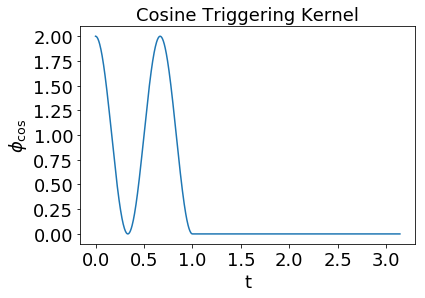

In [5]:
# visualize the triggering kernel
xplot = np.linspace(0,run_time,1024)
plt.plot(xplot, tf_phi.value(xplot))
plt.xlabel('t',fontsize=18)
plt.ylabel('$\phi_{\cos}$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Cosine Triggering Kernel',fontsize=18)
plt.show()

### 2.2 Simulate the Hawkes process model

Simulate 10 point sequences.

In [6]:
num_hist = 10
hp_data_list = []
for i in range(num_hist):
    hawkes = SimuHawkes(baseline=[mu], verbose=False, force_simulation=True, end_time=run_time, seed=1330+i)
    hawkes.set_kernel(0, 0, HPkernel)
    hawkes.simulate()
    hp_data = np.array(hawkes.timestamps)
    hp_data_list += [hp_data]

print('The format of data is: [np.array([[ascending points]]), ..., np.array([[ascending points]])]')

The format of data is: [np.array([[ascending points]]), ..., np.array([[ascending points]])]


This is how toy data look like: 

In [7]:
print(hp_data_list)

[array([[0.02980738, 0.05443853, 0.06975455, 0.09068151, 0.22559281,
        0.27324729, 0.28444682, 0.30943205, 0.37520118, 0.38494087,
        0.39701479, 0.4048886 , 0.50395308, 0.60071973, 0.62654821,
        0.6489709 , 0.65994772, 0.69217574, 0.70519206, 0.72398358,
        0.76518183, 0.82158128, 0.85116462, 0.86572441, 0.8785527 ,
        0.97149041, 1.01077907, 1.04159977, 1.04600553, 1.15996774,
        1.17859891, 1.18845331, 1.24650425, 1.2747151 , 1.32067465,
        1.32197342, 1.380602  , 1.38412186, 1.41276616, 1.42450941,
        1.46464297, 1.46779584, 1.46991066, 1.51950985, 1.53445434,
        1.54223795, 1.54733173, 1.55756259, 1.59996581, 1.60692436,
        1.65507073, 1.6602867 , 1.68116295, 1.70999439, 1.71004817,
        1.74251239, 1.75433409, 1.76380425, 1.77541372, 1.78587303,
        1.81070381, 1.82544602, 1.87200805, 1.8757129 , 1.87993064,
        1.8941145 , 1.91000862, 1.91042106, 1.91222345, 1.91408288,
        1.93645499, 1.94741913, 1.96606727, 1.9

# 3. Experiment - Infer the True Triggering Kernel
### The infer() function is a bit complex. A simple example using it is: infer(your_data, plotted_x)

In [13]:
xplot = np.linspace(0., 2, 128).reshape((1, -1))
rm_f, rstd_f, rm_mu, rstd_mu = gh.infer(hp_data_list, xplot)

/home/rzhang/PycharmProjects/Efficient-Nonparametric-Bayesian-Hawkes-Processes/cov.py:47: RuntimeWarning: divide by zero encountered in true_divide
  integral[:, range(1, nterms), range(1, nterms)] = (ud2 + (0.25 / m * np.sin(2.0 * m * u)))[:, 0, 1:]
/home/rzhang/PycharmProjects/Efficient-Nonparametric-Bayesian-Hawkes-Processes/cov.py:47: RuntimeWarning: invalid value encountered in multiply
  integral[:, range(1, nterms), range(1, nterms)] = (ud2 + (0.25 / m * np.sin(2.0 * m * u)))[:, 0, 1:]


plot the posterior distribution of the triggering kernel

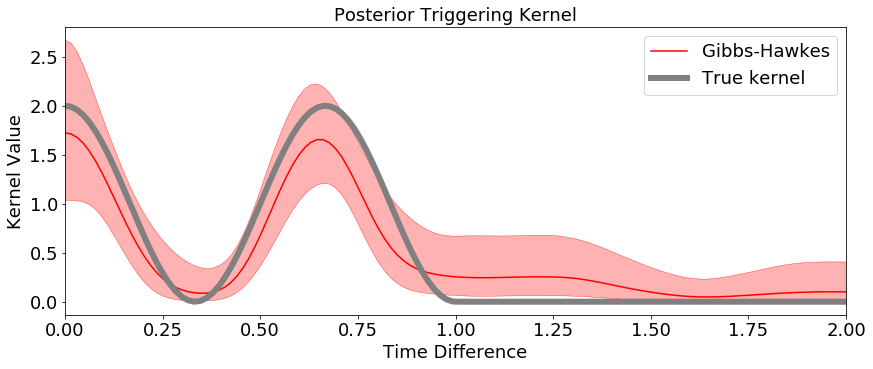

In [14]:
# ploting the estimated posterior distribution

# plot configuration
def plt_config(xplot, tf_phi):
    if tf_phi:
        plt.plot(xplot.flatten(), [tf_phi.value(x) for x in xplot.flatten()], 'gray', lw=6, label="True kernel")
    plt.xlabel('Time Difference', fontsize=18)
    plt.ylabel('Kernel Value', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

plt.figure(figsize = (12,5))
quantiles = gh.squared_normal_quantiles(rm_f.aggregate().flatten(), rstd_f.aggregate().flatten(), [0.1, 0.5, 0.9])
wp.gpplot(xplot[0], quantiles[:, 1], quantiles[:, 0], quantiles[:, 2], fillcol='r', edgecol='r',mulabel='Gibbs-Hawkes')
plt_config(xplot, tf_phi)
plt.tight_layout()
plt.xlim(0,2)
plt.legend(loc='best',prop={'size':18})
plt.title('Posterior Triggering Kernel',fontsize=18)
plt.show()